In [1]:

# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

# Librerías de visualización
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

# TA-Lib: instalación y carga de la librería
import talib

# Otras utilidades
import datetime
import time
import os
import sys

print('Done!')

Using TensorFlow backend.


Done!


In [2]:
#3. Carga el archivo en un dataframe
import pandas as pd
eurusd = pd.read_csv('EURUSD_M30.csv', sep=";") 
eurusd.head()


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
0,2010.01.04,00:00:00,1.43020,1.44560,1.42570,1.43238,11447,0,20
1,2010.01.04,00:30:00,1.43236,1.43329,1.43151,1.43153,475,0,17
2,2010.01.04,01:00:00,1.43151,1.43153,1.42886,1.43133,1178,0,17
3,2010.01.04,01:30:00,1.43146,1.43149,1.42879,1.42886,920,0,17
4,2010.01.04,02:00:00,1.42885,1.42885,1.42673,1.42796,1036,0,17


In [3]:
# crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
df = eurusd.copy()
df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
df['day'] = df['timestamp'].map(lambda x: x.day) 
df['month'] = df['timestamp'].map(lambda x: x.month) 
df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.head())

         DATE      TIME     OPEN     HIGH      LOW    CLOSE  TICKVOL  VOL  \
0  2010.01.04  00:00:00  1.43020  1.44560  1.42570  1.43238    11447    0   
1  2010.01.04  00:30:00  1.43236  1.43329  1.43151  1.43153      475    0   
2  2010.01.04  01:00:00  1.43151  1.43153  1.42886  1.43133     1178    0   
3  2010.01.04  01:30:00  1.43146  1.43149  1.42879  1.42886      920    0   
4  2010.01.04  02:00:00  1.42885  1.42885  1.42673  1.42796     1036    0   

   SPREAD           timestamp  weekday  day  month  hhmm  
0      20 2010-01-04 00:00:00        0    4      1     0  
1      17 2010-01-04 00:30:00        0    4      1    30  
2      17 2010-01-04 01:00:00        0    4      1    60  
3      17 2010-01-04 01:30:00        0    4      1    90  
4      17 2010-01-04 02:00:00        0    4      1   120  


In [4]:
# creo los diferentes indicadores técnicos:

# Medias móviles SMA2, SMA10, SMA20, SMA50, SMA100 (que nos da una idea del precio de cierre actual y las tendencias de mayor temporalidad)
sma2 = talib.SMA(df.CLOSE, timeperiod=2)
sma10 = talib.SMA(df.CLOSE, timeperiod=10)
sma20 = talib.SMA(df.CLOSE, timeperiod=20)
sma50 = talib.SMA(df.CLOSE, timeperiod=50)
sma100 = talib.SMA(df.CLOSE, timeperiod=100)

# MACD:
macd, macdsignal, macdhist = talib.MACD(df.CLOSE, fastperiod=12, slowperiod=26, signalperiod=9)

# Bollinger Bands
upperband, middleband, lowerband = talib.BBANDS(df.CLOSE, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# RSI
rsi = talib.RSI(df.CLOSE, timeperiod=14)

# ATR
atr = talib.ATR(df.HIGH, df.LOW, df.CLOSE, timeperiod=14)

In [5]:
# obtengo columnas a partir de los indicadores y la del precio a obtener. Elimino NaN de los indicadores (velas iniciales)
df['sma2'] = sma2
df['sma10'] = sma10
df['sma20'] = sma20
df['sma50'] = sma50
df['sma100'] = sma100
df['macd'] = macd
df['macdsignal'] = macdsignal
df['macdhist'] = macdhist
df['bollinger_up'] = upperband
df['bollinger_mid'] = middleband
df['bollinger_lo'] = lowerband
df['rsi'] = rsi
df['atr'] = atr
df['price_out'] = df['CLOSE']
df.dropna(inplace=True)
df.head()

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD,timestamp,...,sma100,macd,macdsignal,macdhist,bollinger_up,bollinger_mid,bollinger_lo,rsi,atr,price_out
99,2010.01.06,01:30:00,1.43516,1.43543,1.43342,1.43469,1120,0,17,2010-01-06 01:30:00,...,1.438586,-0.001603,-0.001490,-0.000112,1.441748,1.437523,1.433298,33.346026,0.002415,1.43469
100,2010.01.06,02:00:00,1.43468,1.43575,1.43407,1.43551,1014,0,17,2010-01-06 02:00:00,...,1.438618,-0.001555,-0.001503,-0.000052,1.440777,1.437169,1.433561,38.292720,0.002363,1.43551
101,2010.01.06,02:30:00,1.43550,1.43679,1.43530,1.43675,871,0,17,2010-01-06 02:30:00,...,1.438670,-0.001401,-0.001483,0.000082,1.439857,1.436920,1.433982,44.946473,0.002300,1.43675
102,2010.01.06,03:00:00,1.43674,1.43677,1.43417,1.43491,795,0,17,2010-01-06 03:00:00,...,1.438705,-0.001411,-0.001468,0.000057,1.439440,1.436679,1.433917,38.340084,0.002322,1.43491
103,2010.01.06,03:30:00,1.43490,1.43613,1.43442,1.43565,560,0,17,2010-01-06 03:30:00,...,1.438773,-0.001344,-0.001443,0.000100,1.438685,1.436447,1.434208,42.030431,0.002278,1.43565


In [6]:
dfapp = df.copy()
dfapp.drop(columns=['DATE', 'TIME', 'OPEN', 'HIGH','LOW','CLOSE','TICKVOL', 'VOL', 'SPREAD'], axis=1, inplace=True)

# reordeno las columnas a mi interés (entradas... salidas...)
dfapp = dfapp[['sma2','sma10','sma20','sma50','sma100','macd','macdsignal','macdhist','bollinger_up','bollinger_mid','bollinger_lo','rsi','atr','price_out']]
num_outputs = 1
num_inputs = len(dfapp.columns) - num_outputs

print(dfapp.head())

         sma2     sma10     sma20     sma50    sma100      macd  macdsignal  \
99   1.434935  1.436167  1.437523  1.440736  1.438586 -0.001603   -0.001490   
100  1.435100  1.436015  1.437169  1.440596  1.438618 -0.001555   -0.001503   
101  1.436130  1.436021  1.436920  1.440494  1.438670 -0.001401   -0.001483   
102  1.435830  1.435797  1.436679  1.440356  1.438705 -0.001411   -0.001468   
103  1.435280  1.435712  1.436447  1.440231  1.438773 -0.001344   -0.001443   

     macdhist  bollinger_up  bollinger_mid  bollinger_lo        rsi       atr  \
99  -0.000112      1.441748       1.437523      1.433298  33.346026  0.002415   
100 -0.000052      1.440777       1.437169      1.433561  38.292720  0.002363   
101  0.000082      1.439857       1.436920      1.433982  44.946473  0.002300   
102  0.000057      1.439440       1.436679      1.433917  38.340084  0.002322   
103  0.000100      1.438685       1.436447      1.434208  42.030431  0.002278   

     price_out  
99     1.43469  
100 

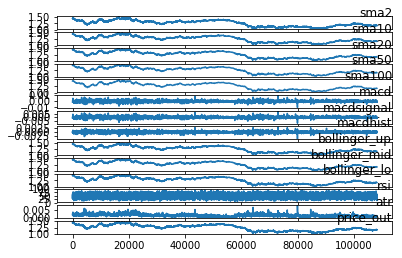

In [7]:
# Visualiza con Matplotlib
# Visualiza 
val = dfapp.values
plt.figure()
for col in range(len(dfapp.columns)):
	plt.subplot(len(dfapp.columns), 1, col+1)
	plt.plot(val[:, col])
	plt.title(dfapp.columns[col], y=0.5, loc='right')
plt.show()

In [8]:
# Creo los scalers de cada columna (entradas y salidas)
values = dfapp.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)

# actualizo el dataframe
df_scaled = pd.DataFrame(data=values, columns=dfapp.columns)
df_scaled.head()

,sma2,sma10,sma20,sma50,sma100,macd,macdsignal,macdhist,bollinger_up,bollinger_mid,bollinger_lo,rsi,atr,price_out
0,0.748131,0.766274,0.778384,0.797748,0.794965,-0.111647,-0.172302,0.113890,0.747559,0.778384,0.779671,-0.368583,-0.440276,0.744335
1,0.748853,0.765602,0.776809,0.797123,0.795106,-0.106793,-0.173843,0.130192,0.743341,0.776809,0.780839,-0.256605,-0.454187,0.747919
2,0.753363,0.765628,0.775699,0.796669,0.795341,-0.091118,-0.171403,0.166111,0.739339,0.775699,0.782719,-0.105985,-0.470700,0.753338
3,0.752049,0.764637,0.774628,0.796051,0.795502,-0.092153,-0.169694,0.159520,0.737525,0.774628,0.782430,-0.255533,-0.465033,0.745296
4,0.749641,0.764261,0.773596,0.795493,0.795808,-0.085318,-0.166726,0.170885,0.734244,0.773596,0.783725,-0.171995,-0.476608,0.748530


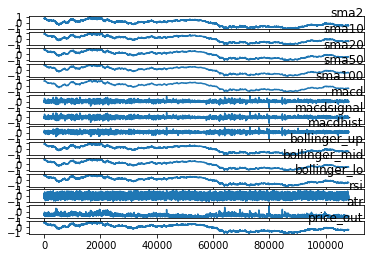

In [9]:
# Visualiza muestras en Matplotlib
plt.figure()
for col in range(len(dfapp.columns)):
	plt.subplot(len(dfapp.columns), 1, col+1)
	plt.plot(values[:, col])
	plt.title(dfapp.columns[col], y=0.5, loc='right')

In [10]:
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df_in.shift(i))
    names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

# Creo columnas para las 48 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 48
num_out_steps = 4
sts_df = series_to_supervised(df_scaled, num_inputs, num_outputs, num_in_steps, num_out_steps)
sts_values = sts_df.values
print('Número de muestras total: ', sts_df.shape[0])
sts_df.head()

Número de muestras total:  108125


,sma2(t-48),sma10(t-48),sma20(t-48),sma50(t-48),sma100(t-48),macd(t-48),macdsignal(t-48),macdhist(t-48),bollinger_up(t-48),bollinger_mid(t-48),...,macdhist(t-1),bollinger_up(t-1),bollinger_mid(t-1),bollinger_lo(t-1),rsi(t-1),atr(t-1),price_out(t),price_out(t+1),price_out(t+2),price_out(t+3)
48,0.748131,0.766274,0.778384,0.797748,0.794965,-0.111647,-0.172302,0.113890,0.747559,0.778384,...,0.149836,0.754929,0.789767,0.794929,0.337323,-0.380238,0.777812,0.775102,0.777943,0.767235
49,0.748853,0.765602,0.776809,0.797123,0.795106,-0.106793,-0.173843,0.130192,0.743341,0.776809,...,0.160850,0.753321,0.791370,0.799792,0.235552,-0.378384,0.775102,0.777943,0.767235,0.768372
50,0.753363,0.765628,0.775699,0.796669,0.795341,-0.091118,-0.171403,0.166111,0.739339,0.775699,...,0.153452,0.753265,0.792202,0.801517,0.176827,-0.407500,0.777943,0.767235,0.768372,0.768765
51,0.752049,0.764637,0.774628,0.796051,0.795502,-0.092153,-0.169694,0.159520,0.737525,0.774628,...,0.156683,0.753783,0.793036,0.802657,0.221644,-0.436429,0.767235,0.768372,0.768765,0.770032
52,0.749641,0.764261,0.773596,0.795493,0.795808,-0.085318,-0.166726,0.170885,0.734244,0.773596,...,0.113162,0.753717,0.792830,0.802310,0.008001,-0.432642,0.768372,0.768765,0.770032,0.772392


In [11]:
print('Values shape: ', sts_values.shape, '\r\n')
num_train_samples = int(sts_df.shape[0] * 0.6)
num_test_samples = int(sts_df.shape[0] * 0.2)
num_validation_samples = sts_df.shape[0] - num_train_samples - num_test_samples

# obtengo los conjuntos train-test-validation
train = sts_values[0:num_train_samples,:]
test = sts_values[num_train_samples:num_train_samples+num_test_samples,:]
validation = sts_values[num_train_samples+num_test_samples:num_train_samples+num_test_samples+num_validation_samples,:]
print('Train shape:', train.shape, ' Test shape:', test.shape, 'Validation shape:', validation.shape, '\r\n')

# obtengo los pares x-y de cada conjunto
x_train, y_train = train[:,:-num_out_steps], train[:,-num_out_steps:]
x_test, y_test = test[:,:-num_out_steps], test[:,-num_out_steps:]
x_validation, y_validation = validation[:,:-num_out_steps], validation[:,-num_out_steps:]
print('X Train shape:', x_train.shape, ' Y Train shape:', y_train.shape, '\r\n')
print('X Test shape:', x_test.shape, ' Y Test shape:', y_test.shape, '\r\n')
print('X Validation shape:', x_validation.shape, ' Y Validation shape:', y_validation.shape, '\r\n')

# acondiciono los formatos a la entrada LSTM (num_samples, num_steps, num_features)
x_train = x_train.reshape((x_train.shape[0], num_in_steps, num_inputs))
x_test = x_test.reshape((x_test.shape[0], num_in_steps, num_inputs))
x_validation = x_validation.reshape((x_validation.shape[0], num_in_steps, num_inputs))

print('X Train reshape:', x_train.shape, ' Y Train reshape:', y_train.shape, '\r\n')
print('X Test reshape:', x_test.shape, ' Y Test reshape:', y_test.shape, '\r\n')
print('X Validation reshape:', x_validation.shape, ' Y Validation reshape:', y_validation.shape, '\r\n')


Values shape:  (108125, 628) 

Train shape: (64875, 628)  Test shape: (21625, 628) Validation shape: (21625, 628) 

X Train shape: (64875, 624)  Y Train shape: (64875, 4) 

X Test shape: (21625, 624)  Y Test shape: (21625, 4) 

X Validation shape: (21625, 624)  Y Validation shape: (21625, 4) 

X Train reshape: (64875, 48, 13)  Y Train reshape: (64875, 4) 

X Test reshape: (21625, 48, 13)  Y Test reshape: (21625, 4) 

X Validation reshape: (21625, 48, 13)  Y Validation reshape: (21625, 4) 



In [14]:
# callback para hacer backup de los pesos en el ordenador local
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self):
    pass
  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  '''
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  def on_epoch_end(self, epoch, logs={}):
    print('... eopch Finished!')
    return
  
  

In [12]:
file_weights = "model_weights_deep.hdf5"

In [15]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

# Crea un modelo LSTM simple de dos capas ocultas
def build_vanilla_lstm(num_cells, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  # la primera capa cuenta con un número de neuronas 'num_cells' y activa el flag 'return_sequences' para que su
  # salida pueda encadenarse a otra capa LSTM, es decir tenga el formato (num_samples, num_steps, num_features)
  # añado una capa de Dropout para eliminar overfitting
  model.add(LSTM(num_cells, return_sequences=True, input_shape=(num_in_steps, num_inputs)))
  model.add(BatchNormalization())
  model.add(Dropout(0.20))

  # la segunda capa cuenta con un número de neuronas 'num_cells' y activa el flag 'return_sequences' para que su
  # salida pueda encadenarse a otra capa LSTM, es decir tenga el formato (num_samples, num_steps, num_features)
  # añado una capa de Dropout para eliminar overfitting
  model.add(LSTM(num_cells, return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.20))

  # la tercera capa es otra capa LSTM con el mismo número de células, pero ya no es necesario especificar el formato de entrada
  model.add(LSTM(num_cells))
  model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  # la capa intermedia Dense, que procesa los features extraidos de las capas lstm
  #model.add(Dense(num_cells, activation='sigmoid', kernel_initializer='normal', kernel_constraint=max_norm(3)))
  #model.add(BatchNormalization())
  #model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  #optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
  #model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])  
  model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  download_weights = DownloadWeights(filepath)
  fitlogger = FitLogger()
  # callback para visualización en tensorboard
  tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)
  callbacks_list = [checkpoint]
  #callbacks_list = [checkpoint, tbCallBack, fitlogger] #, checkpoint, download_weights]

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

num_cells = 128
batch_size = 32
model, callbacks_list = build_vanilla_lstm(num_cells, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)

No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 48, 128)           72704     
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 128)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 48, 128)           131584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 128)           512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)            

In [16]:
# hago un control de epochs manual
epoch_count = 0
loss, val_loss = np.ndarray((0,)), np.ndarray((0,))

def save_weights(model, filename):
  # Serialización del modelo en formato json
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
      json_file.write(model_json)

  # Serializa los pesos a formato HDF5
  model.save_weights(filename)
  print("Saved model to disk")


In [17]:
# Inicia el entrenamiento y validación con los pares de entrenamiento
# para evitar perder los pesos en cierres esporádicos de la conexión del notebook, hago un backup en cada epoch
# de forma manual.
num_epochs = 500
  
print('Iniciando entrenamiento en epoch=',epoch_count)
try:
  history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(x_test,y_test), verbose=2, shuffle=True) 
  # guardo pesos del epoch actual
  save_weights(model, 'model.h5') 

  loss = np.append(loss, np.asarray(history.history['loss']), axis=0)
  val_loss = np.append(val_loss, np.asarray(history.history['val_loss']), axis=0)
  plt.plot(loss[:])
  plt.plot(val_loss[:])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()
  epoch_count += num_epochs

  # Evalúa el funcionamiento con la partición de evaluación
  scores = model.evaluate(x_validation, y_validation, verbose=2)
  print("Model Accuracy: %.2f%%" % (scores[1]*100))
    
except:
  print('Model fit Exception:', sys.exc_info()[0])

  


Iniciando entrenamiento en epoch= 0
Train on 64875 samples, validate on 21625 samples
Epoch 1/500
 - 405s - loss: 0.0926 - acc: 0.2527 - val_loss: 0.0116 - val_acc: 0.2404
Epoch 2/500
 - 382s - loss: 0.0057 - acc: 0.2536 - val_loss: 0.0034 - val_acc: 0.1941
Epoch 3/500
 - 385s - loss: 0.0047 - acc: 0.2641 - val_loss: 0.0067 - val_acc: 0.3101
Epoch 4/500
 - 393s - loss: 0.0051 - acc: 0.2647 - val_loss: 0.0029 - val_acc: 0.3124
Epoch 5/500
 - 471s - loss: 0.0048 - acc: 0.2632 - val_loss: 0.0119 - val_acc: 0.2982
Epoch 6/500
 - 492s - loss: 0.0046 - acc: 0.2612 - val_loss: 0.0026 - val_acc: 0.2352
Epoch 7/500
 - 565s - loss: 0.0044 - acc: 0.2672 - val_loss: 0.0166 - val_acc: 0.2982
Epoch 8/500
 - 543s - loss: 0.0044 - acc: 0.2649 - val_loss: 0.0130 - val_acc: 0.2294
Epoch 9/500
 - 591s - loss: 0.0043 - acc: 0.2676 - val_loss: 0.0040 - val_acc: 0.2982
Epoch 10/500
 - 549s - loss: 0.0043 - acc: 0.2711 - val_loss: 0.0030 - val_acc: 0.1941
Epoch 11/500
 - 539s - loss: 0.0043 - acc: 0.2636 - v

Epoch 94/500
 - 518s - loss: 0.0037 - acc: 0.2610 - val_loss: 0.0054 - val_acc: 0.2982
Epoch 95/500
 - 515s - loss: 0.0038 - acc: 0.2666 - val_loss: 0.0033 - val_acc: 0.3054
Epoch 96/500
 - 516s - loss: 0.0038 - acc: 0.2645 - val_loss: 0.0020 - val_acc: 0.2140
Epoch 97/500
 - 518s - loss: 0.0039 - acc: 0.2643 - val_loss: 9.6122e-04 - val_acc: 0.1941
Epoch 98/500
 - 519s - loss: 0.0038 - acc: 0.2670 - val_loss: 0.0050 - val_acc: 0.2982
Epoch 99/500
 - 518s - loss: 0.0039 - acc: 0.2664 - val_loss: 0.0020 - val_acc: 0.3124
Epoch 100/500
 - 522s - loss: 0.0037 - acc: 0.2626 - val_loss: 0.0019 - val_acc: 0.2982
Epoch 101/500
 - 518s - loss: 0.0040 - acc: 0.2648 - val_loss: 0.0011 - val_acc: 0.2982
Epoch 102/500
 - 513s - loss: 0.0037 - acc: 0.2674 - val_loss: 1.9535e-04 - val_acc: 0.2898
Epoch 103/500
 - 517s - loss: 0.0038 - acc: 0.2648 - val_loss: 0.0022 - val_acc: 0.2192
Epoch 104/500
 - 515s - loss: 0.0038 - acc: 0.2675 - val_loss: 0.0017 - val_acc: 0.2982
Epoch 105/500
 - 517s - loss: 

In [ ]:
# Pruebas de visualización de resultados. Preparación de datos
sample = 0
x_data = x_test
y_data = y_test 


In [ ]:
import math
# Visualización de muestra 'sample'
plt.plot(x_data[sample], marker='o', color='b')
# Visualizo salida esperada
p = np.arange(num_in_steps, num_in_steps+num_out_steps)
plt.plot(p, y_data[sample], marker='o', color='r')
# Realizo predicción del primer conjunto de datos
x = x_data[sample].reshape(1, num_in_steps, 1)
y = y_data[sample].reshape(1,num_out_steps)
predictions = model.predict(x, batch_size=1,verbose=0)
# Visualizo predicción
plt.plot(p, predictions[0], marker='o', color='g')
# Calculo el error RMSE
rmse = math.sqrt(sk.mean_squared_error(y_data[sample], predictions[0], multioutput = 'uniform_average'))
print('RMSE: %f' % rmse)

sample += 1

In [ ]:
# Una vez validado, realiza las predicciones con las entradas de validación, visualiza y obtiene error
x_eval = x_validation
y_eval = y_validation
yhat = np.ndarray(shape=y_eval.shape)
y = np.ndarray(shape=y_eval.shape)
for i in range(x_eval.shape[0]):
  x = x_eval[i]
  x = x.reshape(1, num_in_steps, num_inputs)
  y[i] = y_eval[i]
  predictions = model.predict(x, batch_size=1, verbose=0)
  yhat[i] = predictions

# creo array de resultados, deshago inversión  
yresult = np.ndarray(shape=y.shape)
yresult[:,0] = y[:,0]
yresult[:,1] = yhat[:,0]
#yresult = scaler.inverse_transform(yresult)
 
# visualizo los resultados
plt.plot(yresult[:,0])
plt.plot(yresult[:,1])
#plt.plot(y[:,0])
#plt.plot(yhat[:,0])
plt.xlabel('Nºde Muestra')
plt.ylabel('Precio')
plt.legend(('Y','Yhat'), loc='upper right', shadow=True)
plt.title('EURUSD OHLC en M30') 
    


In [ ]:
plt.plot(yresult[:7000,0])
plt.plot(yresult[:7000,1])